## Code to plot Figure S2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import os
import pickle
import cftime
import matplotlib.dates as mdates

In [9]:
# Read data
#ClOx = Cl + ClO + 2xCl2O2

os.chdir('/gws/nopw/j04/vplume/mchim/netcdf_files/ClOx_monthly')

volc_scenario = ['novolc','volc25','volc50_1','volc50_2','volc98','const']

file_string = '_strat_cl_all_v2.nc'
df_cl = {}
for scenario in volc_scenario:
    file_name = scenario + file_string
    dataset = xr.open_dataset(file_name)
    df_cl[scenario] = dataset['strat_Cl'][:]

file_string = '_strat_clo_all_v2.nc'
df_clo = {}
for scenario in volc_scenario:
    file_name = scenario + file_string
    dataset = xr.open_dataset(file_name)
    df_clo[scenario] = dataset['strat_ClO'][:]

file_string = '_strat_cl2o2_all_v2.nc'
df_cl2o2 = {}
for scenario in volc_scenario:
    file_name = scenario + file_string
    dataset = xr.open_dataset(file_name)
    df_cl2o2[scenario] = dataset['strat_Cl2O2'][:]



In [10]:
def calc_ClOx(cl, clo, cl2o2):
    # convert to ppb

    # total mass in the stratosphere
    df_cl = calc_global_mean(cl)
    df_clo = calc_global_mean(clo)
    df_cl2o2 = calc_global_mean(cl2o2)


    #clox = df_clo*28.97/(35.43+16) * 1e9
    
    #clox = (df_cl*28.97/35.43 + df_clo*28.97/(35.43+16)) * 1e9

    # Calculate ClOx in ppb
    # df = mass mixing ratio 
    # mass mixing ratio x molar mass of air / molar mass of species * 1e9 = concentration in ppb
    clox = (df_cl*28.97/35.43 + df_clo*28.97/(35.43+16) + (df_cl2o2*28.97/(35.43*2+16*2))*2 ) * 1e9
    
    ens_mean = clox.mean(dim='ensemble')
    ens_min = clox.min(dim='ensemble')
    ens_max = clox.max(dim='ensemble')

    return ens_mean, ens_min, ens_max

def calc_global_mean(df):

    # select 60S to 90S
    df = df[:,:,0:24,:]
    
    weights = np.cos(np.deg2rad(df.latitude))
    weights.name = "weights"
    df_w = df.weighted(weights)

    # Global mean
    temp_globalmean = df_w.mean(dim=['latitude','longitude'])

    # Global annual mean
    temp_global_annual = temp_globalmean.groupby('time.year').mean('time')
    
    return temp_global_annual

In [11]:
clox_novolc, min_novolc, max_novolc = calc_ClOx(df_cl['novolc'], df_clo['novolc'], df_cl2o2['novolc'])
clox_volc50_1, min_volc50_1, max_volc50_1 =calc_ClOx(df_cl['volc50_1'], df_clo['volc50_1'], df_cl2o2['volc50_1'])
clox_volc50_2, min_volc50_2, max_volc50_2 =calc_ClOx(df_cl['volc50_2'], df_clo['volc50_2'], df_cl2o2['volc50_2'])
clox_volc25, min_volc25, max_volc25 = calc_ClOx(df_cl['volc25'], df_clo['volc25'], df_cl2o2['volc25'])
clox_volc98, min_volc98, max_volc98 = calc_ClOx(df_cl['volc98'], df_clo['volc98'], df_cl2o2['volc98'])

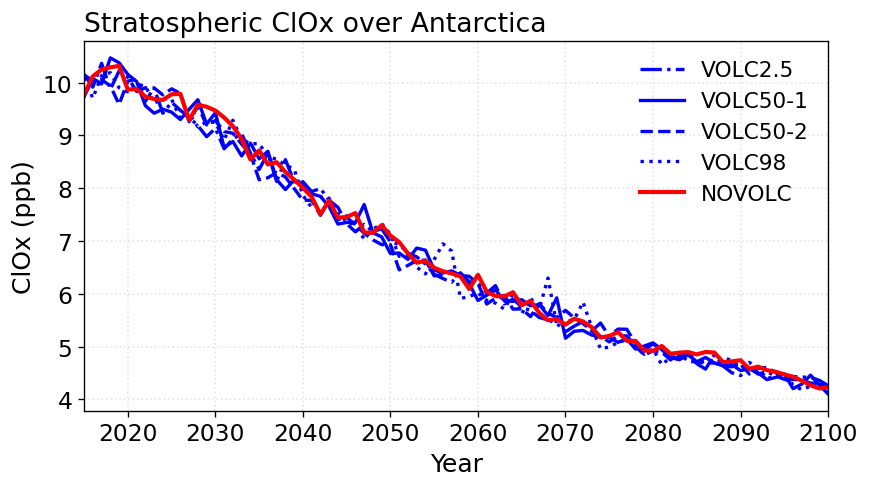

In [13]:
fig, ax = plt.subplots(figsize=(8,4),dpi=120)

year_axis = np.arange(2015,2101,1)

ax.plot(year_axis, clox_volc25, color = 'blue', ls = 'dashdot', label = 'VOLC2.5', linewidth = 2)
ax.plot(year_axis, clox_volc50_1, color = 'blue', ls = 'solid', label = 'VOLC50-1', linewidth = 2)
ax.plot(year_axis, clox_volc50_2, color = 'blue', ls = 'dashed', label = 'VOLC50-2', linewidth = 2)
ax.plot(year_axis, clox_volc98, color = 'blue', ls = 'dotted', label = 'VOLC98', linewidth = 2)

lighlbl = '#C7E9FF'

ax.plot(year_axis, clox_novolc, color = 'red', label = 'NOVOLC', linewidth = 2.5)

ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.set_ylabel('ClOx (ppb)', fontsize=15)
ax.set_xlabel('Year',fontsize=15)
ax.set_title('Stratospheric ClOx over Antarctica', fontsize = 16, loc='left')
ax.set_xlim(2015,2100)
ax.grid(color='grey', which = 'both', linestyle='dotted', linewidth=1, alpha = 0.2)
ax.legend(fontsize = 13, loc = 'upper right', ncol = 1, frameon=False)
